This notebook presents an exploration of the task of finding the residual value of a car over time. 

In [936]:
# Import packages
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

In [951]:
# Dataset accessed via https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data
cwd = os.getcwd()
df = pd.read_csv(cwd+'/vehicles.csv')

### A quick look at the data reveals a few things. 
    
    1). There is missing data in many of the columns
    2). There is clearly a few misrecorded values, notibly the max price of 3.736929e+09, max odometer reading of 1.000000e+07, a Ford F-150 with a manufacture year of 1900.
    3). The scale between variables is very wide, so scaling will need to be applied.
    4). There are several variables that aren't very useful to us, such as region_url


In [46]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [31]:
df.describe(include='all')  

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
count,4.268800e+05,426880,426880,426880,4.268800e+05,425675.000000,409234,421603,252776,249202,...,120519,334022,296677,426812,426810,0.0,426880,420331.000000,420331.000000,426812
unique,NaN,426880,404,413,NaN,NaN,42,29667,6,8,...,4,13,12,241899,360911,NaN,51,NaN,NaN,381536
top,NaN,https://bozeman.craigslist.org/ctd/d/coeur-ale...,columbus,https://spokane.craigslist.org,NaN,NaN,ford,f-150,good,6 cylinders,...,full-size,sedan,white,https://images.craigslist.org/00N0N_1xMPvfxRAI...,35 VEHICLES PRICED UNDER $3000!!! BIG TIME! T...,NaN,ca,NaN,NaN,2021-04-23T22:13:05-0400
freq,NaN,1,3608,2988,NaN,NaN,70985,8009,121456,94169,...,63465,87056,79285,7357,231,NaN,50614,NaN,NaN,12
mean,7.311487e+09,NaN,NaN,NaN,7.519903e+04,2011.235191,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.493940,-94.748599,NaN
std,4.473170e+06,NaN,NaN,NaN,1.218228e+07,9.452120,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.841533,18.365462,NaN
min,7.207408e+09,NaN,NaN,NaN,0.000000e+00,1900.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-84.122245,-159.827728,NaN
25%,7.308143e+09,NaN,NaN,NaN,5.900000e+03,2008.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.601900,-111.939847,NaN
50%,7.312621e+09,NaN,NaN,NaN,1.395000e+04,2013.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.150100,-88.432600,NaN
75%,7.315254e+09,NaN,NaN,NaN,2.648575e+04,2017.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.398900,-80.832039,NaN


# Cleaning the data

### Check for duplicates

In [914]:
df.duplicated().value_counts()

False    426880
dtype: int64

### Remove unnecessary variables

'id', 'url', 'region_url', 'VIN' and 'image_url' don't appear to offer any value in this task, so they can be dropped. The summary also reveals that 'county' only contains NaNs, so it can be dropped too. Also, whilst description could be very useful in providing additional information about a car, for the limited scope of this project it is not practical.

In [952]:
df = df.drop(columns=['id', 'url', 'region_url', 'VIN', 'image_url', 'county', 'description'])

### Remove outliers

Whilst it's virtually impossible to ensure that each value in the dataset is correctly recorded, we can at least remove the major outliers that will impact the distribution of the data. This is commonly done using the z-score or quantile range, however due to the data being highly skewed it doesn't do a perfect job. The below code removes rows with values that are greater than 3 standard deviations. This does a good job at removing the very high values, however, it doesn't remove the ~36,000 rows that have a value of 0.

```python
drop_idx = []
for c in df.columns:
    if df[c].dtype.name != 'object':
        drop_idx.extend(df[np.abs(stats.zscore(df[c])) >= 3].index)
df = df.drop(set(drop_idx))
```
Thus, it seems fitting to use common logic and simply remove cars that have a value < 1,000 and > $2,000,000. Likewise, to remove cars that have a mileage > 250,000.

In [953]:
def remove_outliers(df, col, low, high):
    
    df_NaNs = df[df[col].isna()] # preserves NaNs
    df_without_outliers = df[((df[col] > low) & (df[col] < high))]
    return df_without_outliers.append(df_NaNs, ignore_index=True)

df = remove_outliers(df, 'price', 1_000, 2_000_000.)
df = remove_outliers(df, 'odometer', 0, 250_000.)
df = remove_outliers(df, 'year', 1950, 2023)

### Take care of missing values

I hypothesised that rows with at least one NaN may be more likely to have other missing values, eg. if the manufacturer wasn't listed in an ad then they may have also neglected the model. If this is the case, then these rows are not worth keeping because they offer little information and only serve to damage the rest of the data.

To test this hypothesis I'll drop all rows that don't contain a 'manufacturer' value and analyse the results.

In [148]:
for c in df.columns:
    print(c, 'is missing', round((100 / len(df[c])) * df[c].isna().sum(), 1), '% of values')

region is missing 0.0 % of values
price is missing 0.0 % of values
year is missing 0.3 % of values
manufacturer is missing 3.6 % of values
model is missing 1.1 % of values
condition is missing 37.8 % of values
cylinders is missing 40.9 % of values
fuel is missing 0.7 % of values
odometer is missing 0.6 % of values
title_status is missing 1.7 % of values
transmission is missing 0.5 % of values
drive is missing 30.1 % of values
size is missing 72.0 % of values
type is missing 20.9 % of values
paint_color is missing 28.4 % of values
state is missing 0.0 % of values
lat is missing 0.9 % of values
long is missing 0.9 % of values
posting_date is missing 0.0 % of values


In [149]:
# Remove rows that don't contain 'manufacturer' or 'year' info
df = df[df['transmission'].notna()]

In [150]:
for c in df.columns:
    print(c, 'is missing', round((100 / len(df[c])) * df[c].isna().sum(), 1), '% of values')

region is missing 0.0 % of values
price is missing 0.0 % of values
year is missing 0.3 % of values
manufacturer is missing 3.6 % of values
model is missing 1.1 % of values
condition is missing 37.5 % of values
cylinders is missing 40.7 % of values
fuel is missing 0.6 % of values
odometer is missing 0.5 % of values
title_status is missing 1.6 % of values
transmission is missing 0.0 % of values
drive is missing 30.0 % of values
size is missing 72.0 % of values
type is missing 20.9 % of values
paint_color is missing 28.3 % of values
state is missing 0.0 % of values
lat is missing 0.9 % of values
long is missing 0.9 % of values
posting_date is missing 0.0 % of values


Unfortunately it didn't make much of a difference to the other missing values, so I'll proceed to use interpolation as a means to replace the NaNs. 

### Interpolating the missing values.

I'll begin by interpolating the categorical variable with their most common value.

In [954]:
# Impute categorical variables
cat_vars = ['model', 'manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'posting_date']
for c in cat_vars:
    most_frequent = df[c].mode()[0]
    df[c].fillna(most_frequent,inplace=True)    

### Observe the distrubtion of numeric values.

As for the other values, either the mean or median values may be appropriate for imputation, depending on the  distribtion of the variables.

<AxesSubplot:xlabel='price', ylabel='Count'>

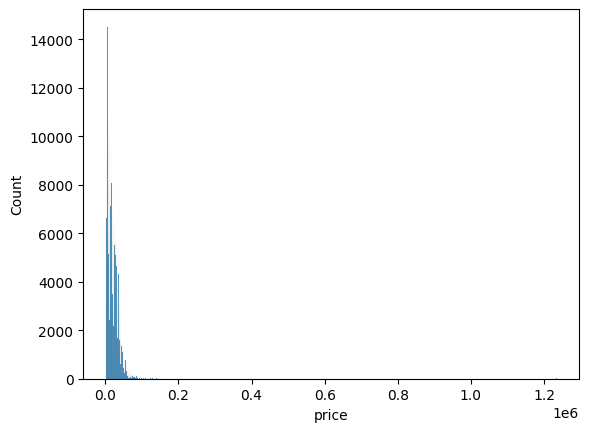

In [75]:
sns.histplot(df['price'])

<AxesSubplot:xlabel='odometer', ylabel='Count'>

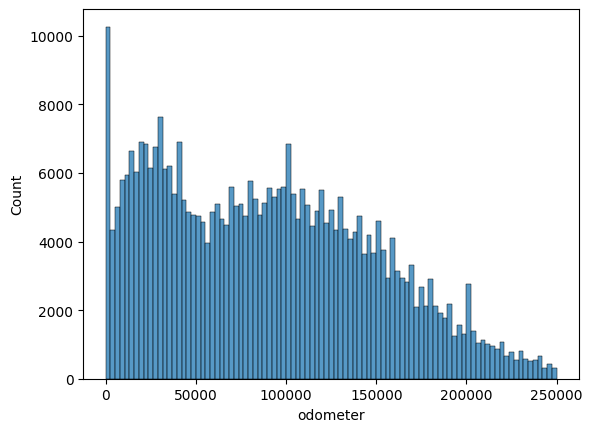

In [83]:
sns.histplot(df['odometer'])

<AxesSubplot:xlabel='year', ylabel='Count'>

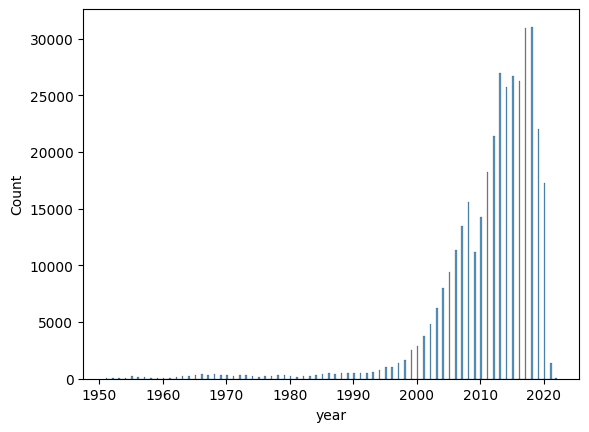

In [113]:
sns.histplot(df['year'])

<AxesSubplot:xlabel='long', ylabel='Count'>

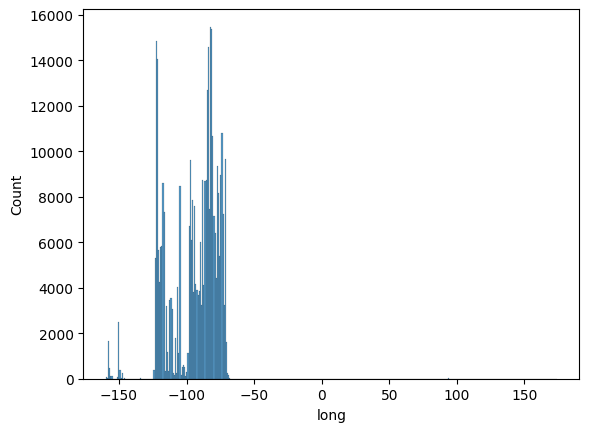

In [12]:
sns.histplot(df['long'])

<AxesSubplot:xlabel='lat', ylabel='Count'>

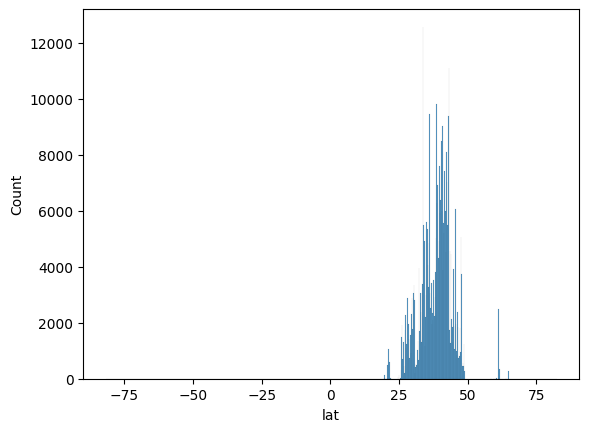

In [13]:
sns.histplot(df['lat'])

The histograms illustrate that price and long have has a large positive skew, while year and lat have a strong negative skew. odometer has a bimodal distribution with a positive skew. Thus the median will be used to interpolate all of the variables.

In [955]:
df['lat'] = df['lat'].fillna(df['lat'].median())
df['long'] = df['long'].fillna(df['long'].median())
df['odometer'] = df['odometer'].fillna(df['odometer'].median())
df['price'] = df['price'].fillna(df['price'].median())
df['year'] = df['year'].fillna(df['year'].median())

### Scaling the variables

The last task before moving on to analying the data is scaling it so that all of the variables are in a similar range, namely between 0 and 1 so that each variable can have an equal influence on the model we end up using.

It might also be a good idea to address the huge positive skew in price. Almost all of the values in price are less than 100,000 - 1/20 of the max value - so maintaining this scale is not ideal. It means that a price of 10k and a price of 20k have a very short distance, which in reality is a major difference. Thus, I will first perform a log transformation on price.

In [115]:
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

In [956]:
df['price'] = normalize(np.log(df['price']))
df['odometer'] = normalize(df['odometer'])
df['year'] = normalize(df['year'])
df['lat'] = normalize(df['lat'])
df['long'] = normalize(df['long'])

<AxesSubplot:xlabel='price', ylabel='Count'>

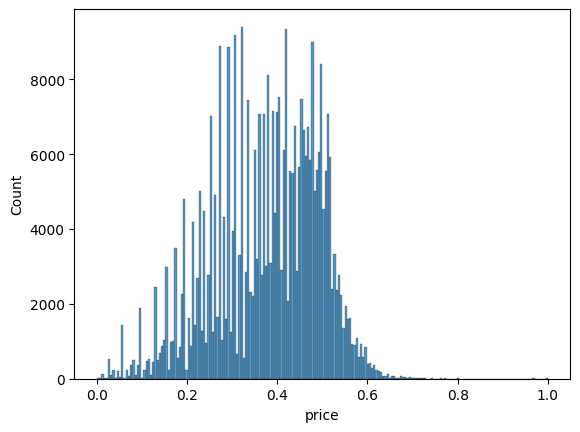

In [357]:
sns.histplot(df['price'])

### Convert ordinal values to a discrete value

In [627]:
print(df['condition'].unique()) # order goes: 'salvage', 'fair', 'good', 'excellent', 'like new', 'new'
print(df['size'].unique())      # order goes: 'sub-compact', 'compact', 'mid-size', 'full-size'

['good' 'excellent' 'fair' 'like new' 'new' 'salvage']
['full-size' 'mid-size' 'compact' 'sub-compact']


In [957]:
classes = {
    'salvage':   1,
    'fair':      2,
    'good':      3,
    'excellent': 4,
    'like new':  5,
    'new':       6
}

df['condition'] = df['condition'].map(classes)

In [958]:
classes = {
    'sub-compact':  1,
    'compact':      2,
    'mid-size':     3,
    'full-size':    4
}

df['size'] = df['size'].map(classes)

### Convert nominal values to one-hot encodings

There's a limit to the number of dummy columns we can use to represent a column, as additional columns create a "combination explosion", as each variable increases the uncertainty in the data. 

As the data below shows, model has WAY too many classes to be converted into dummies - I'll address this a little further down the page.

state also has a pretty large number of classes, so I might omit it from general analysis but will look at a few states individually later on.

All of the other columns have a fairly low number of classes so I will convert them to dummies.

In [870]:
def get_length(df, column):
    print('Unique values in', column,':', len(df[column].unique()))

ordinal_vars = ['cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state', 'model']
for c in ordinal_vars:
    get_length(df, c)


Unique values in cylinders : 8
Unique values in fuel : 5
Unique values in title_status : 6
Unique values in transmission : 3
Unique values in drive : 3
Unique values in type : 13
Unique values in paint_color : 12
Unique values in state : 51
Unique values in model : 25989


In [959]:
# Convert ordinal values to dummies

def add_dummies(df, column):
    # Convert ordinal values to dummies
    dummies = pd.get_dummies(df[column])
    # include original variable name in each dummy column
    for i in range(len(dummies.columns)):
        old_name = dummies.columns[i]
        new_name = column + '_' + old_name
        dummies.rename(columns={old_name:new_name}, inplace=True)
    # add dummies to df and remove original column
    return dummies
df2 = df
ordinal_vars = ['cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color']
for c in ordinal_vars:
    dummies = add_dummies(df, c)
    for i in range(len(dummies.columns)):
        dummy_name = dummies.columns[i]
        df[dummy_name] = dummies[dummy_name]

As the below shows, there is a fairly uniform distribution of values for each state, so it is important to keep all of them. However due to the large number of classes it doesn't appear practical to generate a different dummy for each variable. The two main options are to 

    1). create dummies for the top N states with highest frequency, or 
    2). Set aside the state information for now and then use it to do state-level analysis later on

The same goes for the car model, however the issue is much more severe. The large number of classes in model is clearly due to mislabelled, with dubious values such as: '♿', '♿ vmi', '𝓜𝓮𝓻𝓬𝓮𝓭𝓮𝓼 𝓫𝓮𝓷𝔃 𝓶𝓵 350', '🔥GMC Sierra 1500 SLE🔥 4X4 🔥' appearing in the dataset.

model name is very important to this research topic, and it would be a worth while task to clean them using regex or maybe an NLP model such as a transformer. However given the limited scope of the project it is not possible. 

A simpler option - purely for the purposes of this project - is to remove any rows that have a frequency less than 10. This is because most of the value we will get from this research is at a per model level, so cars with a very rare model wont provide as much value.

Applying this constraint drops the number of rows from 370,653 to 321,798 which is a reasonable trade off considering the remaining data will be much richer.

Now there are only 3729 classes for model, which is still way too many to create dummies. Like with state, I will omit model from the general search and use it for model level research later on.

In [649]:
counts = df['state'].value_counts()
len(counts), max(counts), min(counts), (sum(counts) / len(counts)), np.median(counts)

(51, 42158, 366, 7267.705882352941, 5435.0)

In [650]:
# model has way to many classes to create dummies for
len(df['model'].unique()), len(df['model'])

(25989, 370653)

In [960]:
# Remove rows that have a model frequency < 10
counts = df['model'].value_counts()
counts = counts[counts > 10]
df = df[df['model'].isin(counts.index)]
len(df['model'].unique()), len(df['model'])

(3729, 321798)

### Cleaning posting_date

posting_date has string values representing the time stamp when the the date was posted. This isn't particularly meaningful to a statistical mode on its own. 

A more useful approach would be to discretise it. The first part of the timestamp has the date, which we can convert into an integer, where 0 is the earliest recorded posting_date. 

It might have also been useful to convert the date to the day of the year to capture the seasonal effect of car sales, however as the data only has postings for the month of May, I decided to skip it.

It might also be worth creating another variable that records the time that the posting was made to identify if certain parts of the day impact the sale price. To do this we can create a variable called posting_time that has the time converted to minutes, where midnight is 0 and 23:59 is 1439.

In [961]:
# Format: 2021-05-04T12:31:18-0500
# Convert posting_date to day from first posting
dates = []
for tstamp in df['posting_date'].values:
    date, _ = tstamp.split("T")
    y, m, d = date.split("-")
    dates.append(dt.date(int(y), int(m), int(d)))

min_date = min(dates)

for i in range(len(dates)):
    dates[i] = (dates[i] - min_date).days
df['posting_date_in_days'] = dates

/var/folders/b4/8vzsfph501zf5h1xv_7l64dh0000gp/T/ipykernel_33781/1358064636.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['posting_date_in_days'] = dates


In [962]:
# Convert posting_date to time in minutes
times = []
for tstamp in df['posting_date'].values:
    _, time = tstamp.split("T")
    time, _ = time.split("-")
    h, m, s = time.split(":")
    times.append(int(h)*60+int(m))
df['posting_time_in_mins'] = times

/var/folders/b4/8vzsfph501zf5h1xv_7l64dh0000gp/T/ipykernel_33781/4254083825.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['posting_time_in_mins'] = times


# Analyse the data

Before we go any further, Let's have a quick glance at the data.

<AxesSubplot:xlabel='manufacturer'>

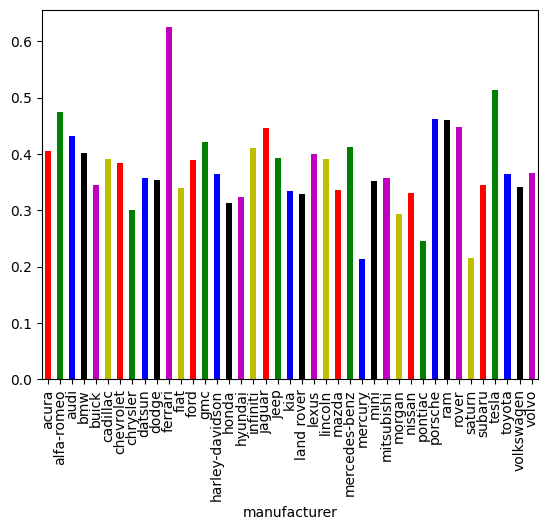

In [768]:
# There aren't any surprises with car prices, with Ferrari followed by Tesla being the priciest 
df.groupby('manufacturer')['price'].mean().plot(kind='bar', color=['r', 'g', 'b', 'k', 'm', 'y'])

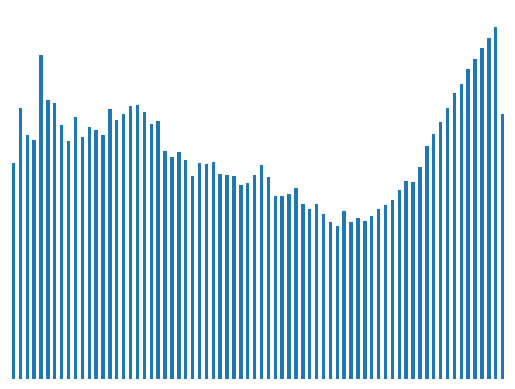

In [745]:
# Interestingly, price seems to be have a steep decline within the first thirty years, and then slowly increases.
# This is likely due to older cars having a "classic car" status, though more research needs to be done to explain it.
df.groupby('year')['price'].mean().plot(kind='bar')
plt.axis('off')
plt.show()

<AxesSubplot:xlabel='paint_color', ylabel='price'>

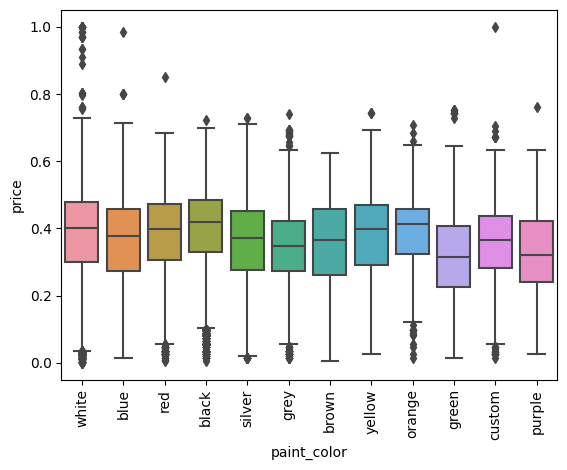

In [769]:
# It's interesting that colour seems not to have too much of an impact on price. 
# It's also interesting that white has a large number of extreme outliers
plt.xticks(rotation=90)
sns.boxplot(data=df, x='paint_color', y='price')

<AxesSubplot:xlabel='state', ylabel='price'>

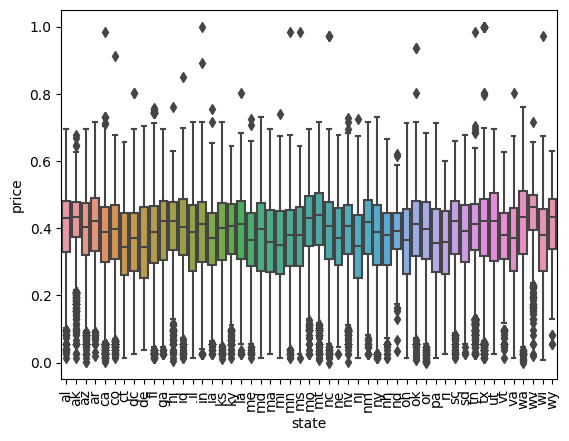

In [947]:
# Neither does state. And the states I expected to have higher prices: CA, NY are on the lower side.
plt.xticks(rotation=90)
sns.boxplot(data=df, x='state', y='price')

<AxesSubplot:xlabel='long'>

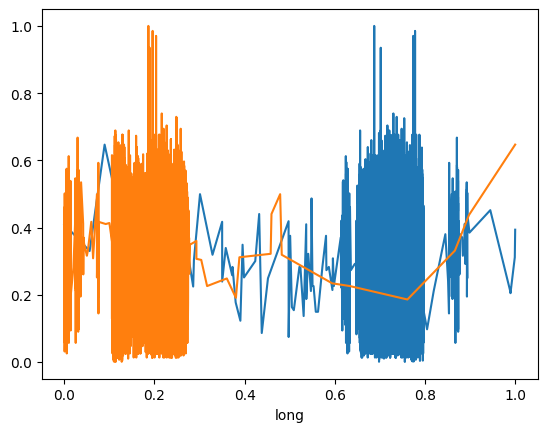

In [737]:
# Despite state not having an impact, there does appear to be some impact caused by geo-coordinates.
df.groupby('lat')['price'].mean().plot()
df.groupby('long')['price'].mean().plot()

# Feature selection

Now I will attempt to identify which set of independent variables are useful for predicting car price. The more IVs we include will weaken our pedictive ability due to the dreaded "curse of dimensionality", so it is important to limit our model to only include those that will have a significant impact.

I should also note that I will be implementing a general price predictor. Although it is likely more desirable to implement a model for predicting the price by individual car model - or at least by manufacturer, as well as by location, due to the limited scope of the project I will not be able to achieve this.

The correlation plot below reveals some interesting things, though nothing too surprising.
    
    * odometer has a strong negative impact on price
    * whilst year has a strong positive impact on price
    * size also seems to have a positive impact, with larger vehicles being worth more
    
Based on this, I wont drop any columns due to high correlation.

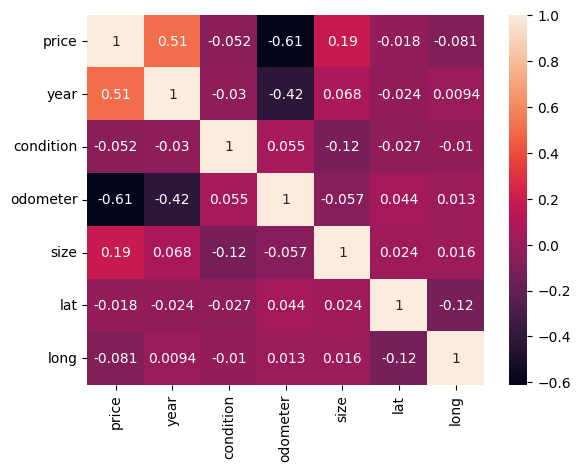

In [780]:
# Generate correlation plot
orig_vars = ['region', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state', 'lat', 'long', 'posting_date']
temp_df = df.loc[:, df.columns.isin(orig_vars)]
ax = sns.heatmap(temp_df.corr(), annot=True)

### Random Forest

Random Forest is both a powerful feature selection method and predictive model that creates many decision trees and polls the results. 
They are much more poweful than their little brother Decision Tree, which typically over-generalises to the seen data.
There are a few important hyper-parameters to consider when implementing the RF:

    * n_estimators, int, default=100, ie the number of trees to use. Increasing the number of trees seems to increase the accuracy of the model up to a point without overfitting to the data. Whilst more is better, the increased computational cost is prohibitive. I chose 500, as it is fairly quick on my machine and increasing it any further didn't appear to improve the results.
    * max_depth, int, default=None, ie how deep can a tree be. Whilst increasing a trees depth can improve the results, it does lead to overfitting. Choosing a good max_depth is important for prediction, however for the task of feature selection it is not necessary, thus I'll leave it to the default.
    * n_jobs, int, default=None, ie how many jobs to run in parallel. Clearly we want to use as many as possible to speed up the process, so I set it to be -1, which uses all available processes.
    * All of the other default settings are reasonable for the task.



In [963]:
# Omit the dv and uncleaned categorical vars
omit = ['price', 'region', 'manufacturer', 'model', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'paint_color', 'state', 'posting_date', 'title_status']
features = df.loc[:, ~df.columns.isin(omit)]

In [829]:
random_forest = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)
random_forest.fit(features, df['price'])

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)

In [830]:
for name, importance in zip(features, random_forest.feature_importances_):
    if importance > 0.01:
        print(name, ":", importance)

year : 0.5013998250064106
condition : 0.01869474513689637
odometer : 0.11286711111271432
lat : 0.04137118993260679
long : 0.04447914633481114
cylinders_4 cylinders : 0.042199188544970144
cylinders_8 cylinders : 0.02579818151160048
fuel_diesel : 0.047923749970794655
drive_fwd : 0.03376115371073794
type_sedan : 0.01767014310247265
posting_date_in_days : 0.017610936912036995
posting_time_in_mins : 0.02416140247756874


The results of the Random Forest identify 12 variables of interest that have a correlation with price > 1%. year and odometer have the highest value with 50% and 11% respectively. This appears to be in line with the correlation heat map results above.


There are many other feature selection techniques:

    * embedded methods like LASSO regression
    * unsupervised clustering methods like KNN
    * dimensionality reduction methods like PCA
    * wrapper methods like forward selection/backward elimination

However given the time constraints, I was unable to experiement with these methods.

# Training the model

Split the data into train and test set, and remove all of the insignificant variables we discovered in the last stage.


In [966]:
keep = ['year', 'condition', 'odometer', 'lat', 'long', 'cylinders_4 cylinders', 'cylinders_8 cylinders', 'fuel_diesel', 'drive_fwd', 'type_sedan', 'posting_date_in_days', 'posting_time_in_mins']
train, test = train_test_split(df, test_size=0.2)
train_x = df.loc[:, train.columns.isin(keep)]
test_x = df.loc[:, test.columns.isin(keep)]
train_y = train['price']
test_y = test['price']